In [1]:
# import duckdb
import pandas as pd
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%reload_ext sql
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:default:

There's a new jupysql version available (0.7.9), you're running 0.7.8. To upgrade: pip install jupysql --upgrade
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
# Plot display settings
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.family'] = ['Inter', 'sans-serif']

pd.set_option('display.max_colwidth', 3000)
pd.set_option("display.max_columns", None)

# Analyzing play-by-play data

In [3]:
%sql play_by_play << SELECT * FROM read_csv_auto('../archive/csv/play_by_play.csv') ORDER BY game_id DESC, wctimestring LIMIT 40;
play_by_play.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game_id,eventnum,eventmsgtype,eventmsgactiontype,period,wctimestring,pctimestring,homedescription,neutraldescription,visitordescription,score,scoremargin,person1type,player1_id,player1_name,player1_team_id,player1_team_city,player1_team_nickname,player1_team_abbreviation,person2type,player2_id,player2_name,player2_team_id,player2_team_city,player2_team_nickname,player2_team_abbreviation,person3type,player3_id,player3_name,player3_team_id,player3_team_city,player3_team_nickname,player3_team_abbreviation,video_available_flag
0,0029901189,0,12,0,1,12:50 PM,12:00,NaN,Start of 1st Period (12:50 PM EST),NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
1,0029901189,1,10,0,1,2:16 PM,12:00,Jump Ball Baker vs. Olowokandi: Tip to Odom,NaN,NaN,NaN,NaN,4.0,452,Vin Baker,1.610613e+09,Seattle,SuperSonics,SEA,5.0,1709,Michael Olowokandi,1.610613e+09,Los Angeles,Clippers,LAC,5.0,1885,Lamar Odom,1.610613e+09,Los Angeles,Clippers,LAC,0
2,0029901189,3,4,0,1,2:16 PM,11:44,Lewis REBOUND (Off:0 Def:1),NaN,NaN,NaN,NaN,4.0,1740,Rashard Lewis,1.610613e+09,Seattle,SuperSonics,SEA,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
3,0029901189,2,2,1,1,2:16 PM,11:46,NaN,NaN,MISS Olowokandi 11' Jump Shot,NaN,NaN,5.0,1709,Michael Olowokandi,1.610613e+09,Los Angeles,Clippers,LAC,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
4,0029901189,5,4,0,1,2:17 PM,11:31,Borrell REBOUND (Off:1 Def:0),NaN,NaN,NaN,NaN,4.0,1953,Lazaro Borrell,1.610613e+09,Seattle,SuperSonics,SEA,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0


In [78]:
%%sql play_by_play_n_games <<
SELECT extract(year from game.game_date) as year, count(*) as n_games
FROM 
(
  SELECT game_id
  FROM read_csv_auto('../archive/csv/play_by_play.csv') as pbp
  GROUP BY game_id
) as pbp
LEFT JOIN read_csv_auto('../archive/csv/game.csv') as game ON pbp.game_id = game.game_id
GROUP BY extract(year from game.game_date)
ORDER BY year
;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
play_by_play_n_games: pd.DataFrame

<AxesSubplot:xlabel='year'>

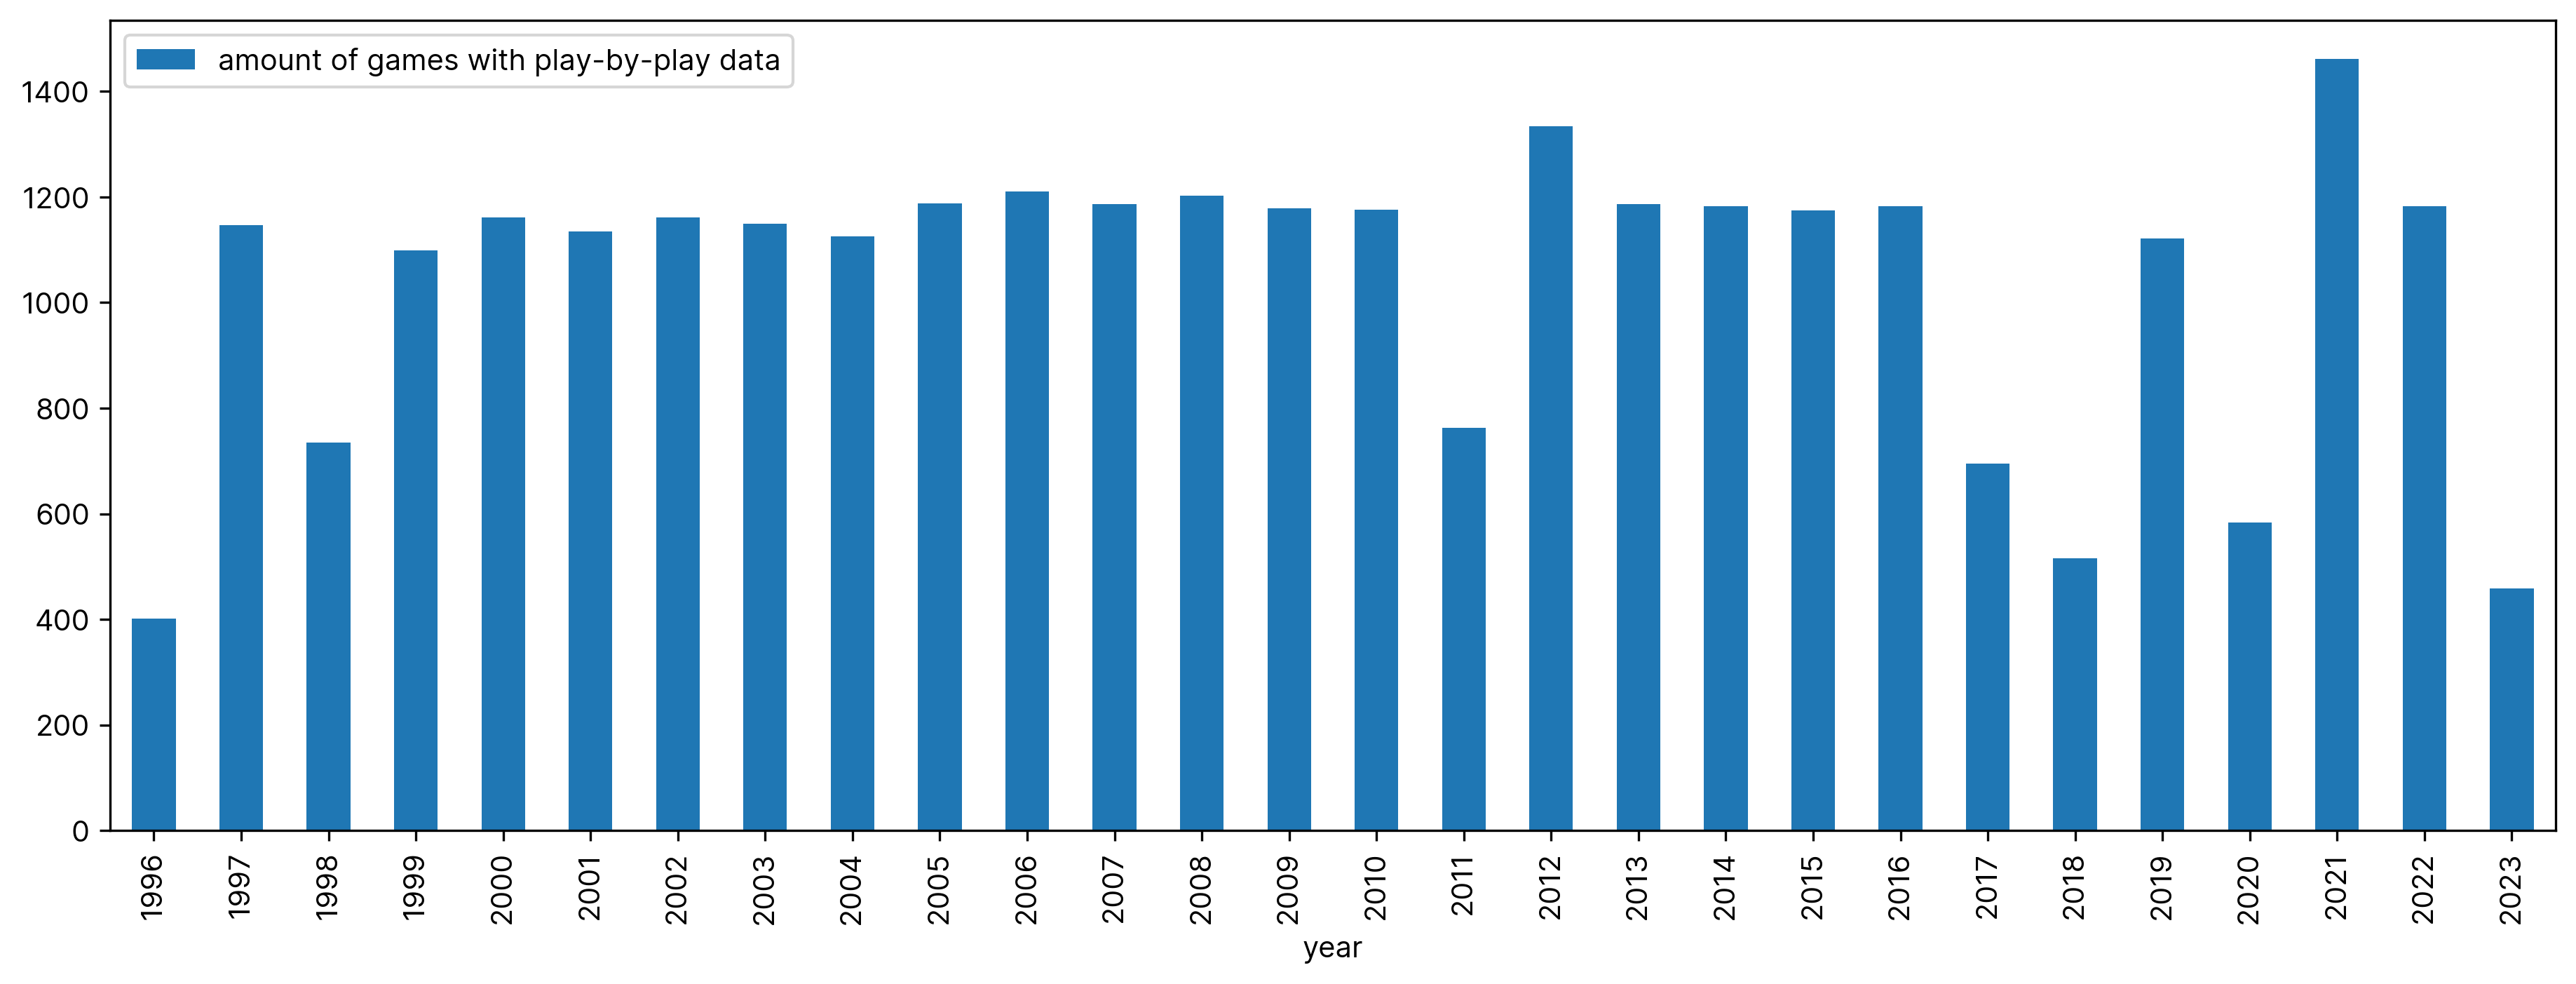

In [7]:
play_by_play_n_games.plot.bar(x='year', y='n_games', figsize=(15, 5), label="amount of games with play-by-play data")

# Wie viele Plays pro katgorie gibt es?

In [19]:
from enum import Enum

class EventMsgType(Enum):
    FIELD_GOAL_MADE = 1
    FIELD_GOAL_MISSED = 2
    FREE_THROWfree_throw_attempt = 3
    REBOUND = 4
    TURNOVER = 5
    FOUL = 6
    VIOLATION = 7
    SUBSTITUTION = 8
    TIMEOUT = 9
    JUMP_BALL = 10
    EJECTION = 11
    PERIOD_BEGIN = 12
    PERIOD_END = 13
    UNKN_14 = 14
    UNK_15 = 15
    UNK_16 = 16
    UNK_17 = 17
    UNK_18 = 18

In [46]:
%sql play_by_play_evtmsg << SELECT eventmsgtype, COUNT(*) as count FROM read_csv_auto('../archive/csv/play_by_play.csv') GROUP BY eventmsgtype ORDER BY COUNT(*) ASC;
play_by_play_evtmsg: pd.DataFrame

play_by_play_evtmsg['eventmsgtype'] = play_by_play_evtmsg['eventmsgtype'].apply(lambda x: f"{EventMsgType(x).name} {x}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

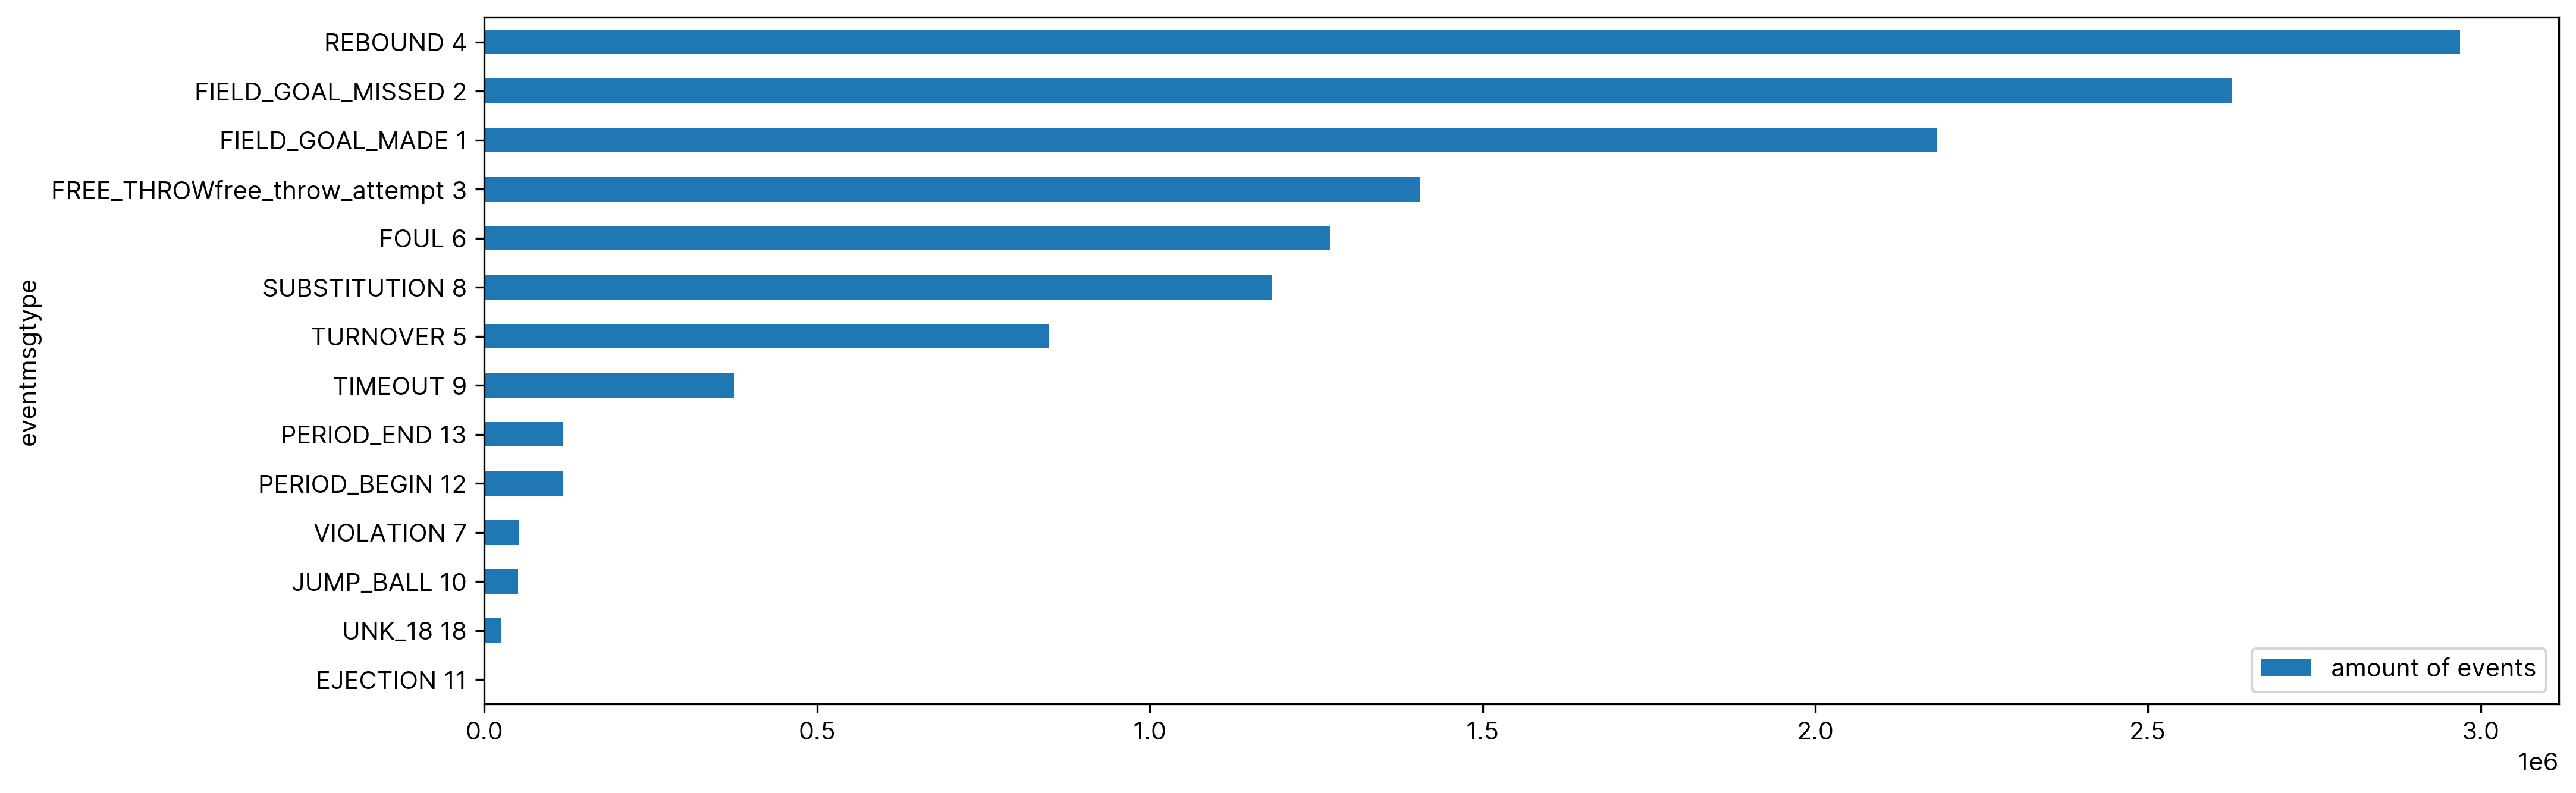

In [52]:
# plot play_by_play_evtmsg, labels on the right
play_by_play_evtmsg.plot.barh(x='eventmsgtype', y='count', figsize=(15, 5), label="amount of events")
# legend on the right, in the chart
plt.legend(loc='lower right')

# plt.xticks(rotation=15, ha='right')
plt.show()

# Fouls im zeitlichen verlauf

In [69]:
%sql SELECT game_id, COUNT(*) FROM read_csv_auto('../archive/csv/play_by_play.csv') WHERE eventmsgtype = 6 GROUP BY game_id ORDER BY COUNT(*) DESC;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,game_id,count_star()
0,0020600478,81
1,0029700072,81
2,0029900004,81
3,0029900002,80
4,0029700176,79
...,...,...
29089,0020900947,20
29090,0022200628,20
29091,0022000674,20
29092,0021001102,18


In [81]:
%%sql play_by_play_n_fouls <<
SELECT extract(year from game.game_date) as year, sum(n_fouls) as n_fouls
FROM 
(
  SELECT game_id, COUNT(*) as n_fouls
  FROM read_csv_auto('../archive/csv/play_by_play.csv')
  WHERE eventmsgtype = 6
  GROUP BY game_id
  ORDER BY COUNT(*) DESC
) as pbp
LEFT JOIN read_csv_auto('../archive/csv/game.csv') as game ON pbp.game_id = game.game_id
GROUP BY year
ORDER BY year
;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [89]:
# normalize fouls by play_by_play_n_games and store in new variable
play_by_play_n_fouls['n_fouls_per_game'] = play_by_play_n_fouls['n_fouls'] / play_by_play_n_games['n_games']
play_by_play_n_fouls

,year,n_fouls,n_fouls_normalized,n_fouls_per_game
0,1996,18750.0,46.758105,46.758105
1,1997,52619.0,45.875327,45.875327
2,1998,33288.0,45.289796,45.289796
3,1999,51411.0,46.779800,46.779800
4,2000,55657.0,47.938846,47.938846
5,2001,50731.0,44.736332,44.736332
6,2002,52291.0,45.039621,45.039621
7,2003,51304.0,44.651001,44.651001
8,2004,51200.0,45.511111,45.511111
9,2005,55969.0,47.111953,47.111953


<BarContainer object of 28 artists>

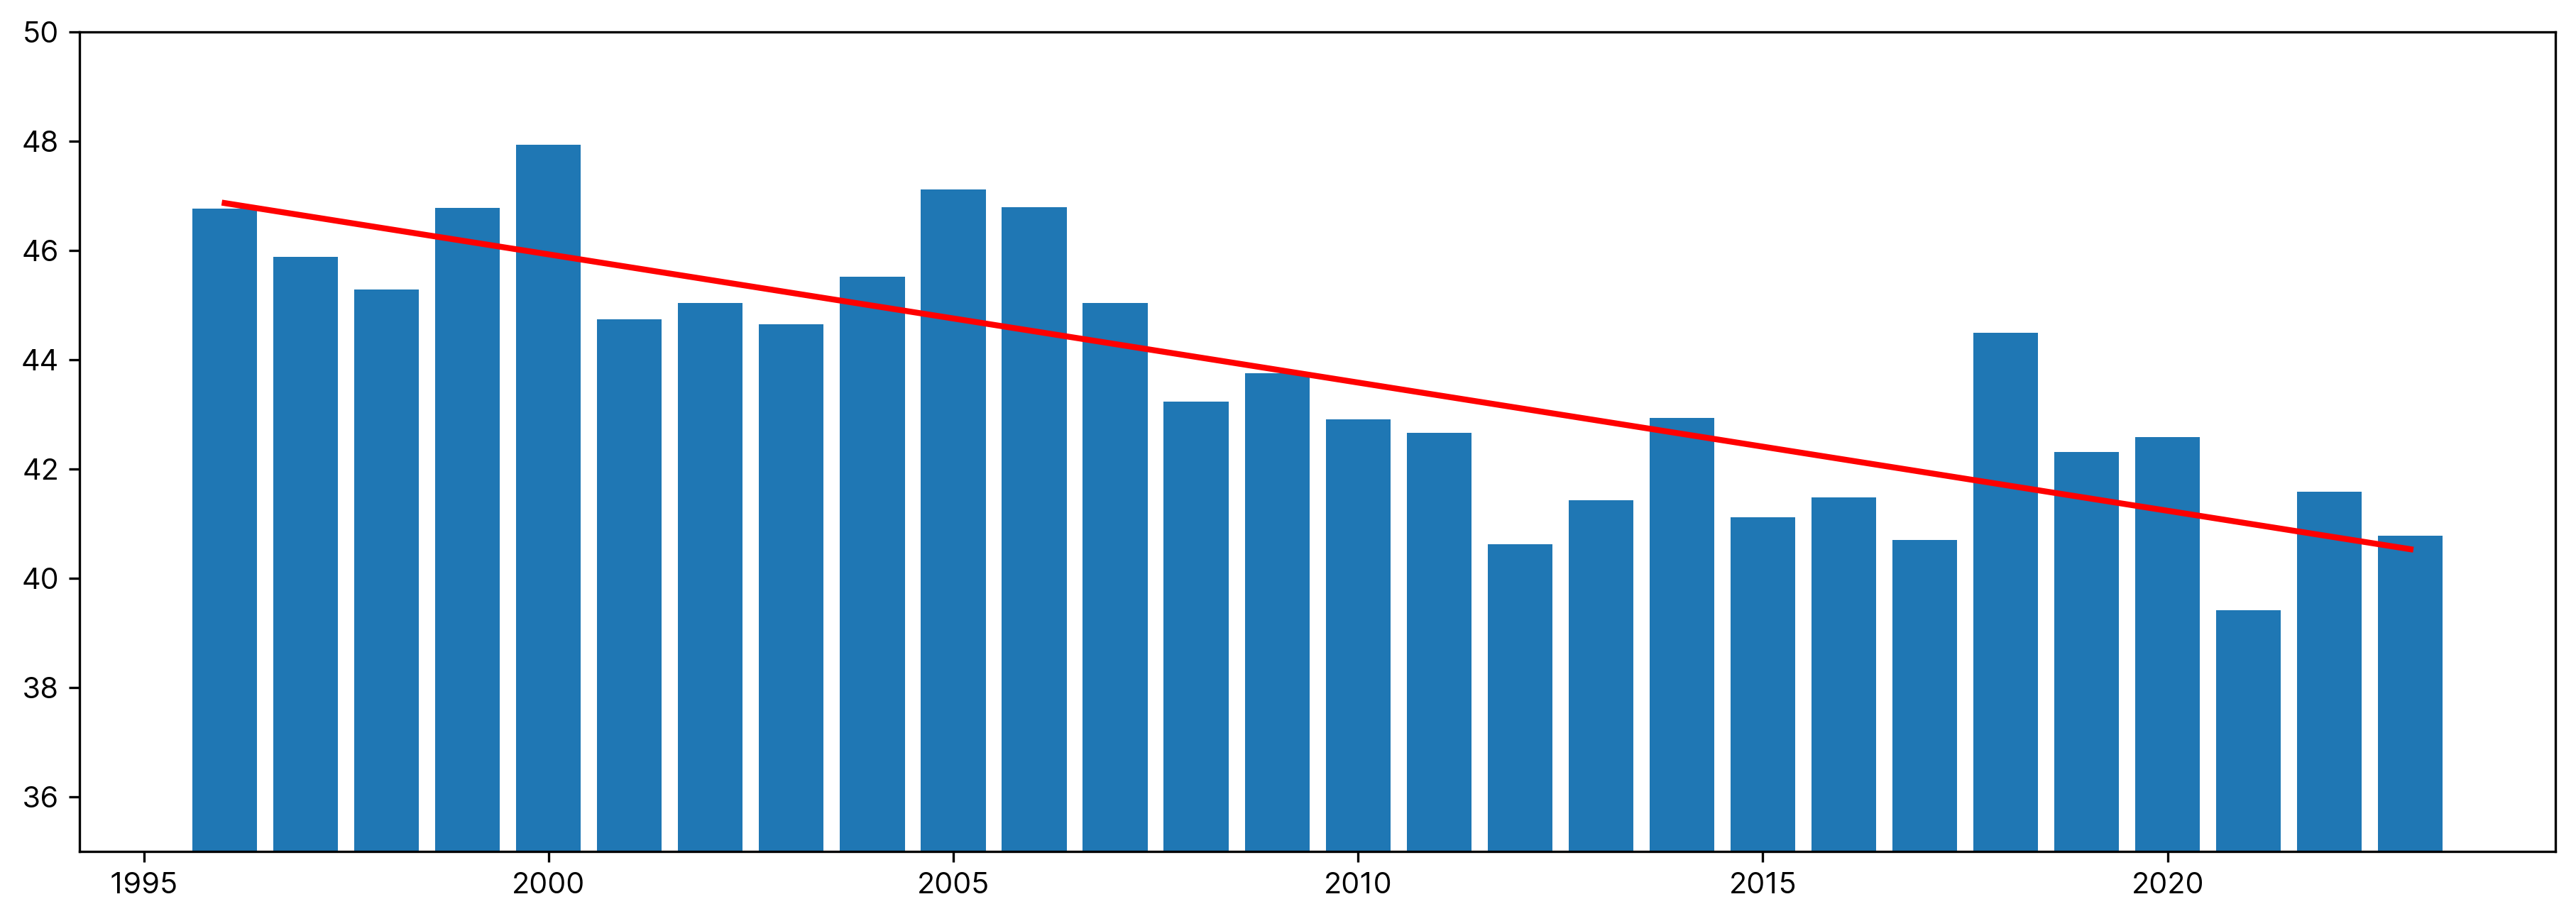

In [112]:
# start y axis at 30
# plt.ylim(35, 50)
# play_by_play_n_fouls.plot.bar(x='year', y='n_fouls_per_game', figsize=(15, 5), label="amount of fouls per game")

# add linear regression line
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array(play_by_play_n_fouls['year']).reshape((-1, 1))
y = np.array(play_by_play_n_fouls['n_fouls_per_game'])

model = LinearRegression().fit(x, y)
# set figsize to 15x5 
plt.figure(figsize=(15, 5))
# start y axis at 30
plt.ylim(35, 50)

plt.plot(x, model.predict(x), color='red', linewidth=2, label="linear regression")
# plot fouls per game as bar chart
plt.bar(x='year', height='n_fouls_per_game', data=play_by_play_n_fouls, label="amount of fouls per game")


